SyntaxError: invalid syntax. Perhaps you forgot a comma? (1309768907.py, line 1)

In [23]:
import requests
import pandas as pd
from datetime import datetime

# URL für die Zeitstempel
timestamps_url = 'https://www.smard.de/app/chart_data/410/DE/index_PT15M.json'

# Abrufen der Zeitstempel
timestamps_response = requests.get(timestamps_url)
timestamps = timestamps_response.json()

# Filtern der Zeitstempel für Juli 2025
july_timestamps = [ts for ts in timestamps if '2025-07' in ts]

# URL für die Preisdaten
prices_url = f'https://www.smard.de/app/chart_data/410/DE/410_DE_hour_{july_timestamps[0]}.json'

# Abrufen der Preisdaten
prices_response = requests.get(prices_url)
prices_data = prices_response.json()

# Extrahieren der relevanten Daten
data = []
for entry in prices_data:
    timestamp = entry['timestamp']
    price = entry['value']
    data.append({'timestamp': timestamp, 'price': price})

# Umwandeln in DataFrame
df = pd.DataFrame(data)

# Speichern als CSV
df.to_csv('strompreise_juli_2025.csv', index=False)

print("Daten erfolgreich abgerufen und gespeichert!")


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [3]:
#import os
import json
import requests
#import time


# Rückgabe der Strompreise und WindOnshoreProduktion in Viertelstundenauflösung ab Montag dem 23.01.2023 00:00 Uhr
response1 = requests.get("https://www.smard.de/app/table_data/4067/DE/4067_DE_quarterhour_1674428400000.json")
response2 = requests.get("https://www.smard.de/app/chart_data/4169/DE/4169_DE_quarterhour_1674428400000.json")

# Ausgabe ob Abruf geklappt hat
print(response1.status_code)

print("\n")

print(response2.status_code)
#print(response2.json())

# Auslesen des aktuellen Wertes für den Strompreis (TODO)
    #print(len(response2.series.values))

# Sortieren der Rückgaben und schreiben in Datei
def jprint1(obj):
    json.dump(obj,open('smard_wind_onshore_4067.json','w'),indent=4, sort_keys=True)
    # Debugging
    #text = json.dumps(obj, sort_keys=True, indent=4)
    #print(text)

jprint1(response1.json())


def jprint2(obj):
    json.dump(obj,open('smard_prices_4169.json','w'),indent=4, sort_keys=True)
    # Debugging
    #text = json.dumps(obj, sort_keys=True, indent=4)
    #print(text)

jprint2(response2.json())

200


200


In [27]:
import datetime
import requests
import matplotlib.pyplot as plt

# 1) Verfügbare Startpunkte abrufen
index_url = "https://www.smard.de/app/chart_data/4169/DE/index_quarterhour.json"
resp = requests.get(index_url)
resp.raise_for_status()
index_data = resp.json()
# Je nach Struktur: z. B. index_data["data"] oder ["timestamps"]
timestamps = index_data.get("data") or index_data.get("timestamps") or []

# 2) Filtern ab deinem Startdatum
start_ms = 1672614000000
valid_timestamps = [ts for ts in timestamps if ts >= start_ms]

x, y = [], []

# 3) Für jeden gültigen Timestamp Daten laden
for ts in valid_timestamps:
    url = f"https://www.smard.de/app/chart_data/4169/DE/4169_DE_quarterhour_{ts}.json"
    r = requests.get(url)
    if r.status_code != 200:
        print("Fehler bei", ts, "-", r.status_code)
        continue
    data = r.json()
    for t, val in data.get("series", []):
        if val is not None:
            dt = datetime.datetime.fromtimestamp(t/1000, tz=datetime.timezone.utc)
            x.append(dt)
            y.append(val)


In [28]:
# Preise als DataFrame darstellen

import pandas as pd

# x = Liste timestamps/datetimeobj, y = Liste der DA-Preise in Euro/MWh
da_price = pd.DataFrame({
    "timestamp": x,
    "price_eur_mwh": y
})

# Zeitstempel als Index
da_price.set_index("timestamp", inplace=True)

# Spalten umbenennen
da_price = da_price.rename(
    columns={
    "timestamp": "Zeitstempel",
    "price_eur_mwh": "DA-Preis in Euro/MWh"
    }
)

print(da_price.head())



                           DA-Preis in Euro/MWh
timestamp                                      
2023-01-01 23:00:00+00:00                 57.91
2023-01-01 23:15:00+00:00                 57.91
2023-01-01 23:30:00+00:00                 57.91
2023-01-01 23:45:00+00:00                 57.91
2023-01-02 00:00:00+00:00                 51.67


In [40]:
# Speichern als CSV

da_price.to_csv("smard_DA_prices_quarterhourly.csv")

In [ ]:
# Tagesdurchschnitt berechnen

daily_avg = da_price.resample("D").mean()
print(daily_avg.head()) 


                           DA-Preis in Euro/MWh
timestamp                                      
2023-01-31 00:00:00+00:00            121.202538
2023-02-28 00:00:00+00:00            128.390923
2023-03-31 00:00:00+00:00            102.401142
2023-04-30 00:00:00+00:00            100.832486
2023-05-31 00:00:00+00:00             81.646371


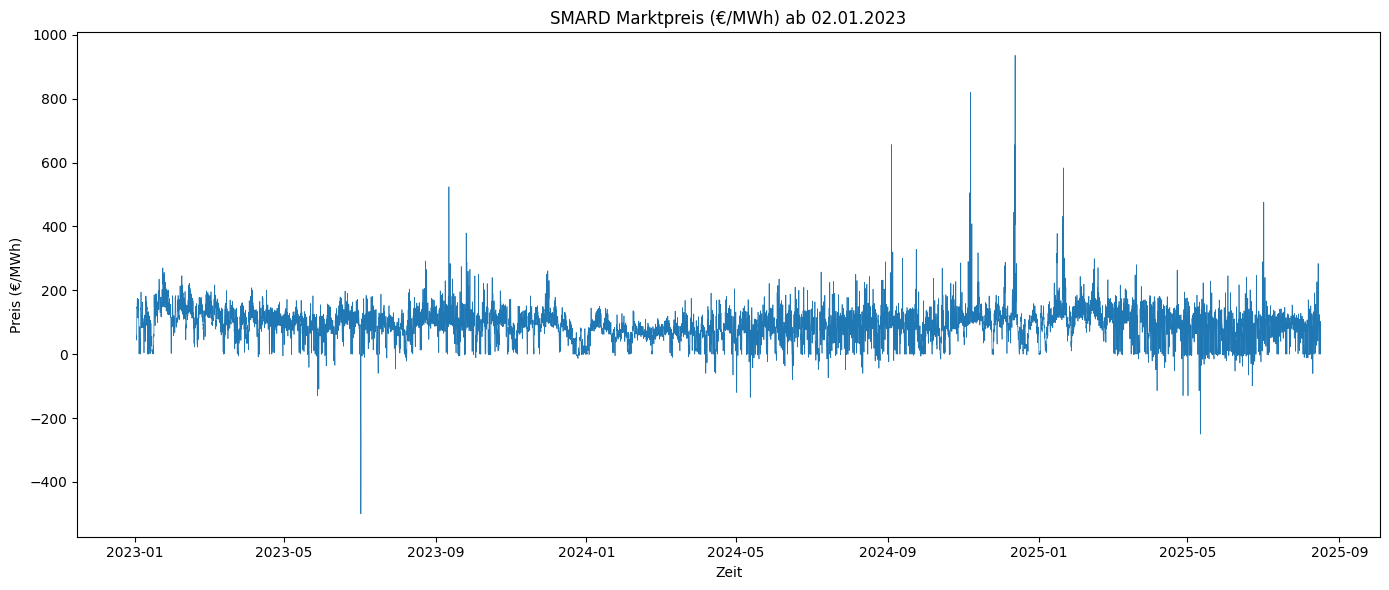

In [34]:
# 4) Plotten der kombinierten Daten
plt.figure(figsize=(14,6))
plt.plot(x, y, '-', linewidth=0.5)
plt.title("SMARD Marktpreis (€/MWh) ab 02.01.2023")
plt.xlabel("Zeit")
plt.ylabel("Preis (€/MWh)")
plt.tight_layout()
plt.show()


In [ ]:
# Speichern als csv

